In [1]:
import numpy as np
import pandas as pd
import scipy.io
import pyriemann as pr
import networkx as nx
import os

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
%run Pipeline_for_SPD.ipynb

Populating the interactive namespace from numpy and matplotlib


In [2]:

labels = pd.read_csv("data/targets 28.02.2018.csv", sep=";").reset_index(drop=True)
# labels = labels[labels["patient_number"].isin(mri_data["index_r"])]

idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "NoTLE"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
DE_idx = labels["target"].notnull()
E_idx = labels["E/no E"].notnull()
D_idx = labels["D/no D"].notnull()
E_C_idx = labels["E/C"].notnull()
D_C_idx = labels["D/C"].notnull()
TLE_noE_idx = labels["TLE/no E"].notnull()
TLE_C_idx = labels["TLE/C"].notnull()
DE_E_idx = labels["DE/E"].notnull()

DE_D_idx = E_C_idx == False

In [3]:
labels.head()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
0,P001,2,2,5,2.0,6.0,6.0,NaN,2.0,NaN,NaN,NaN,NaN
1,P002,3,2,1,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,7.0
2,P003,2,2,5,2.0,6.0,6.0,NaN,2.0,NaN,NaN,NaN,NaN
3,P004,1,4,1,NaN,4.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,P006,2,2,5,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,7.0


In [4]:
patients = labels['patient_number']

In [5]:
data = []
for l in patients:
    X_new = pd.read_csv('./data/clean_last/{}.csv'.format(l), index_col=0)
    data.append(np.array(X_new))

1. Epilepsy / no epilepsy
2. Depression / no depression
3. Epilepsy / control
4. Depression / control
5. TLE / no epilepsy
6. TLE / control
7. Epilepsy with depression / only epilepsy
8. Epilepsy with depression / only depression

## Threshold = 0.2

In [6]:
tr = 0.2
scoring = 'roc_auc'

### Epilepsy  / No Epilepsy

Target distribution: 
4    50
2    50
Name: E/no E, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 50 folds for each of 27 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 88.9min


(training took 5706.8030397892s)

Training MDM...
Fitting 50 folds for each of 3 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 95.1min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.3min finished


(training took 140.80840301513672s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 0.01, clf__gamma = 1, clf__kernel = r...",0.5728,0.170353
LR,"clf__C = 0.0001, metric = riemann",0.5392,0.175315
KNN,"metric = riemann, n_neighbors = 5",0.5672,0.166410
MDM,metric = riemann,0.5360,0.183478


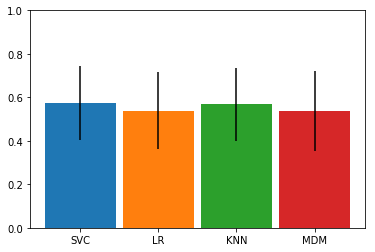

Best model: 
SVC
clf__C = 0.01
clf__gamma = 1
clf__kernel = rbf
metric = riemann
mean = 0.5636000000000001
std = 0.18734737788397252


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

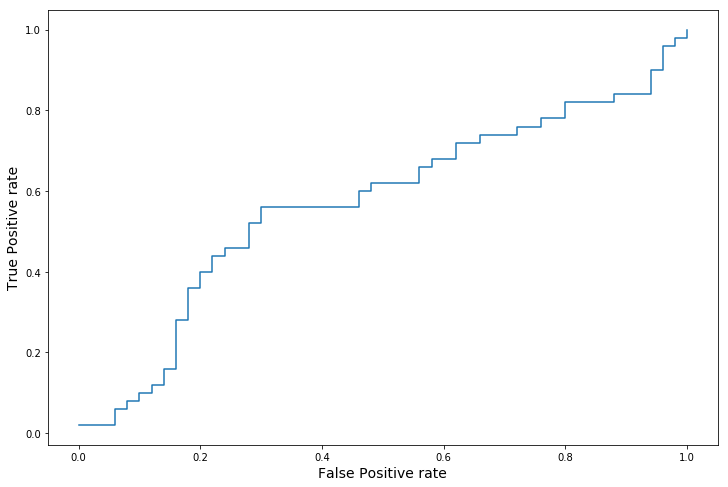

auc = 0.5692


,False Positive rate (fixed),False Negative rate
0,0.10,0.90
1,0.15,0.84
2,0.20,0.60
3,0.30,0.44


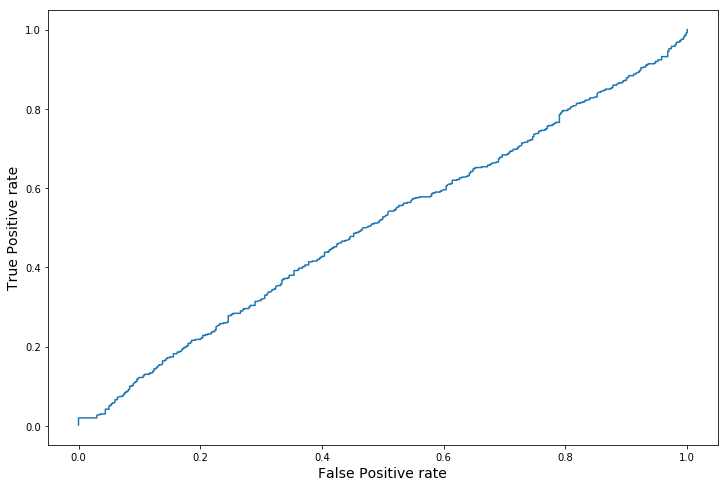

auc = 0.505616


,False Positive rate (fixed),False Negative rate
0,0.10,0.878
1,0.15,0.826
2,0.20,0.780
3,0.30,0.680


,False Positive rate (fixed),False Negative rate
0,0.10,0.878
1,0.15,0.826
2,0.20,0.780
3,0.30,0.680


In [7]:
# n_splits = 2
n_splits = 10
y = labels["E/no E"]
pos_label = label_to_idx["E"]
pipe = SPD_pipeline(tr, 0.1)

### Pipeline training
best_model_E, grid_cv_svc_E, grid_cv_lr_E, grid_cv_mdm_E, grid_cv_knn_E = pipe.train_grid_cv(
    data, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')

### Validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data)
scores_E = cross_val_score(best_model_E, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs=-1)
  
print("mean =", scores_E.mean())
print("std =", scores_E.std())

### Save model and predictions
pipe.save_model(best_model_E, "models/fmri_rim_E.pkl")
probas_E = pipe.repeated_cross_val_predict_proba(best_model_E, data, y, cv=cv, pos_label=pos_label, file = 'models/rim_E_prediction.csv')

### ROC-AUC
# average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_E, pos_label, E_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_E, pos_label, E_idx)
pipe.get_fpr_fnr(fpr, tpr)

## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Depression  / No depression

Target distribution: 
5    50
1    50
Name: D/no D, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 50 folds for each of 27 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 67.7min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed: 73.5min finished


(training took 4411.995056152344s)

Training MDM...
Fitting 50 folds for each of 3 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.1min finished


(training took 124.98002910614014s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 0.0001, clf__gamma = 1, clf__kernel =...",0.6716,0.164394
LR,"clf__C = 0.0001, metric = riemann",0.4144,0.171163
KNN,"metric = riemann, n_neighbors = 5",0.5064,0.177739
MDM,metric = riemann,0.4192,0.169184


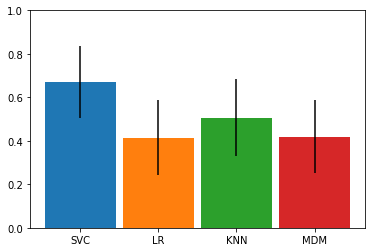

Best model: 
SVC
clf__C = 0.0001
clf__gamma = 1
clf__kernel = rbf
metric = riemann
mean = 0.6457999999999998
std = 0.17722968148704663


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

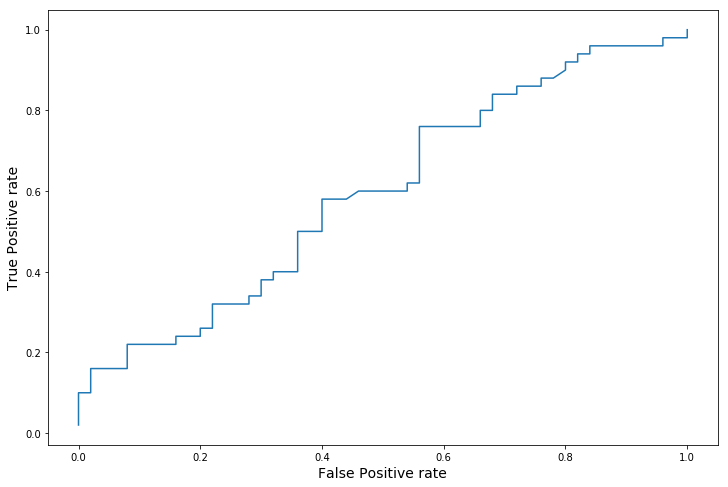

auc = 0.596


,False Positive rate (fixed),False Negative rate
0,0.10,0.78
1,0.15,0.78
2,0.20,0.74
3,0.30,0.62


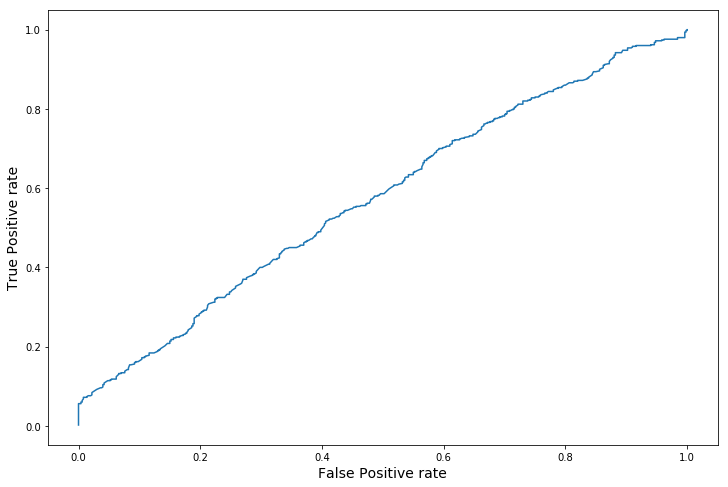

auc = 0.574024


,False Positive rate (fixed),False Negative rate
0,0.10,0.838
1,0.15,0.786
2,0.20,0.718
3,0.30,0.600


In [7]:
n_splits = 10
y = labels["D/no D"]
pos_label = label_to_idx["D"]
pipe = SPD_pipeline(tr, 0.1)

# Pipeline training
best_model_D, grid_cv_svc_D, grid_cv_lr_D, grid_cv_mdm_D, grid_cv_knn_D = pipe.train_grid_cv(
    data, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data)
scores_D = cross_val_score(best_model_D, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
  
print("mean =", scores_D.mean())
print("std =", scores_D.std())


pipe.save_model(best_model_D, "models/fmri_rim_D.pkl")
probas_D = pipe.repeated_cross_val_predict_proba(best_model_D, data, y, cv=cv, pos_label=pos_label, file = 'models/rim_D_prediction.csv')

# average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_D, pos_label, D_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_D, pos_label, D_idx)
pipe.get_fpr_fnr(fpr, tpr)

## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Epilepsy / Control

Target distribution: 
0.0    25
2.0    25
Name: E/C, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min


(training took 216.1642460823059s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   29.0s finished


(training took 29.909783124923706s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 1, clf__gamma = 0.01, clf__kernel = r...",0.5784,0.128738
LR,"clf__C = 1, metric = euclid",0.5296,0.192426
KNN,"metric = riemann, n_neighbors = 5",0.5376,0.219404
MDM,metric = riemann,0.4576,0.129036


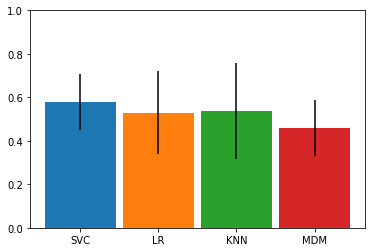

Best model: 
SVC
clf__C = 1
clf__gamma = 0.01
clf__kernel = rbf
metric = riemann
mean = 0.5579999999999999
std = 0.13116401945655679


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

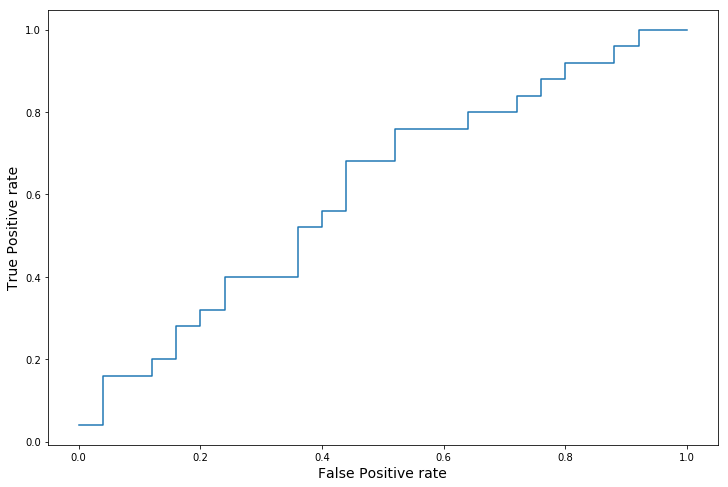

auc = 0.608


,False Positive rate (fixed),False Negative rate
0,0.10,0.84
1,0.15,0.80
2,0.20,0.68
3,0.30,0.60


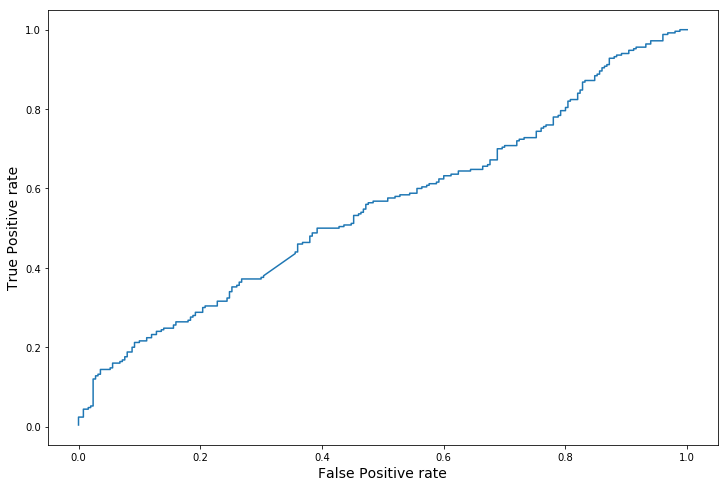

auc = 0.553072


,False Positive rate (fixed),False Negative rate
0,0.10,0.784
1,0.15,0.752
2,0.20,0.712
3,0.30,0.624


In [6]:
n_splits = 5

y = labels[E_C_idx]["E/C"]
data_EC = [data[i] for i in np.where(E_C_idx == True)[0]]
pos_label = label_to_idx["E"]
pipe = SPD_pipeline(tr, 0.1)


best_model_EC, grid_cv_svc_EC, grid_cv_lr_EC, grid_cv_mdm_EC, grid_cv_knn_EC = pipe.train_grid_cv(
    data_EC, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')

cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_EC)
scores_EC = cross_val_score(best_model_EC, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_EC.mean())
print("std =", scores_EC.std())


pipe.save_model(best_model_EC, "models/fmri_rim_EC.pkl")
probas_EC = pipe.repeated_cross_val_predict_proba(best_model_EC, data_EC, y, cv=cv, pos_label=pos_label, file = 'models/rim_EC_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_EC, pos_label, E_C_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_EC, pos_label, E_C_idx)
pipe.get_fpr_fnr(fpr, tpr)

## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Depression / Control

Target distribution: 
0.0    25
1.0    25
Name: D/C, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


(training took 243.3126962184906s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   35.2s finished


(training took 36.25381898880005s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 1, clf__gamma = 0.0001, clf__kernel =...",0.5080,0.027129
LR,"clf__C = 1, metric = riemann",0.6112,0.205062
KNN,"metric = riemann, n_neighbors = 5",0.5648,0.156489
MDM,metric = riemann,0.5616,0.221841


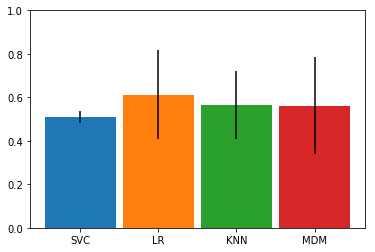

Best model: 
LR
clf__C = 1
metric = riemann
mean = 0.6023999999999999
std = 0.18921479857558712


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

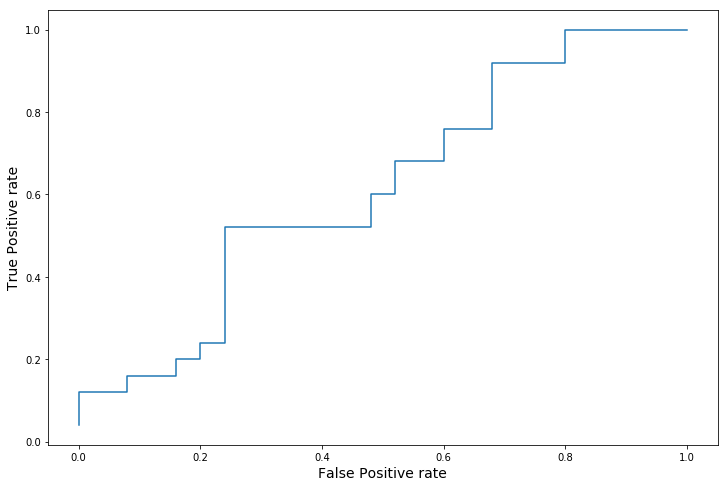

auc = 0.6144000000000001


,False Positive rate (fixed),False Negative rate
0,0.10,0.84
1,0.15,0.84
2,0.20,0.76
3,0.30,0.48


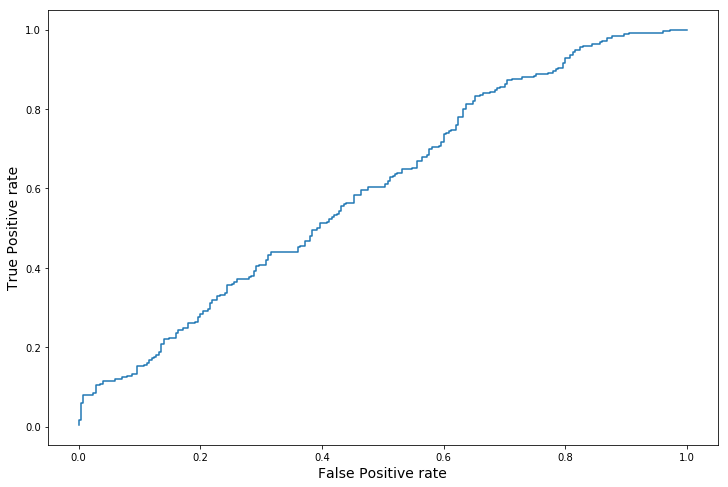

auc = 0.6001120000000001


,False Positive rate (fixed),False Negative rate
0,0.10,0.848
1,0.15,0.776
2,0.20,0.716
3,0.30,0.592


In [7]:
# 0.57
n_splits = 5

y = labels[D_C_idx]["D/C"]
data_DC = [data[i] for i in np.where(D_C_idx == True)[0]]
pos_label = label_to_idx["D"]
pipe = SPD_pipeline(tr, 0.1)


best_model_DC, grid_cv_svc_DC, grid_cv_lr_DC, grid_cv_mdm_DC, grid_cv_knn_DC = pipe.train_grid_cv(
    data_DC, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_DC)
scores_DC = cross_val_score(best_model_DC, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_DC.mean())
print("std =", scores_DC.std())


pipe.save_model(best_model_DC, "models/fmri_rim_DC.pkl")
probas_DC = pipe.repeated_cross_val_predict_proba(best_model_DC, data_DC, y, cv=cv, pos_label=pos_label, file = 'models/rim_DC_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DC, pos_label, D_C_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DC, pos_label, D_C_idx)
pipe.get_fpr_fnr(fpr, tpr)
                           
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### TLE / no Epilepsy

Target distribution: 
4.0    50
6.0    30
Name: TLE/no E, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 15 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.3min


(training took 721.9060208797455s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed: 12.0min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   48.8s finished


(training took 50.34655523300171s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 0.01, clf__gamma = 1, clf__kernel = r...",0.641667,0.177983
LR,"clf__C = 0.0001, metric = euclid",0.590667,0.163373
KNN,"metric = riemann, n_neighbors = 5",0.536667,0.157410
MDM,metric = riemann,0.528000,0.134719


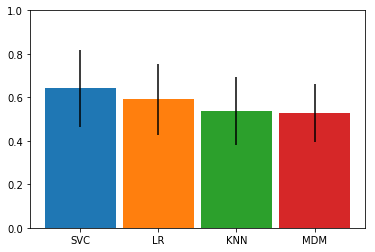

Best model: 
SVC
clf__C = 0.01
clf__gamma = 1
clf__kernel = rbf
metric = euclid
mean = 0.6491666666666667
std = 0.14609024988379998


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

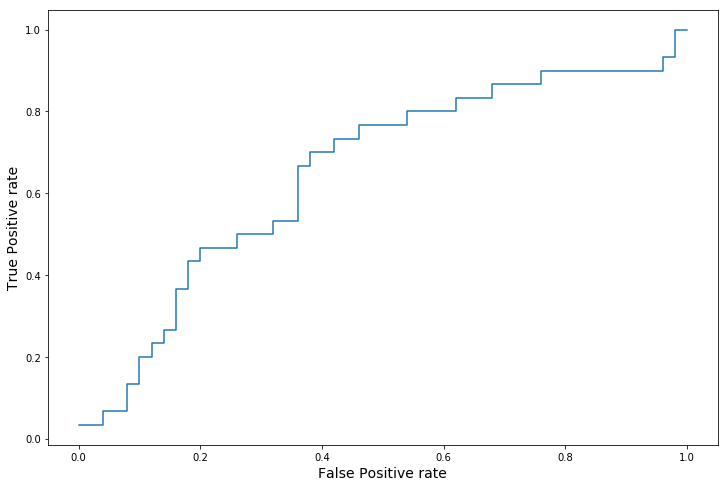

auc = 0.65


,False Positive rate (fixed),False Negative rate
0,0.10,0.800000
1,0.15,0.733333
2,0.20,0.533333
3,0.30,0.500000


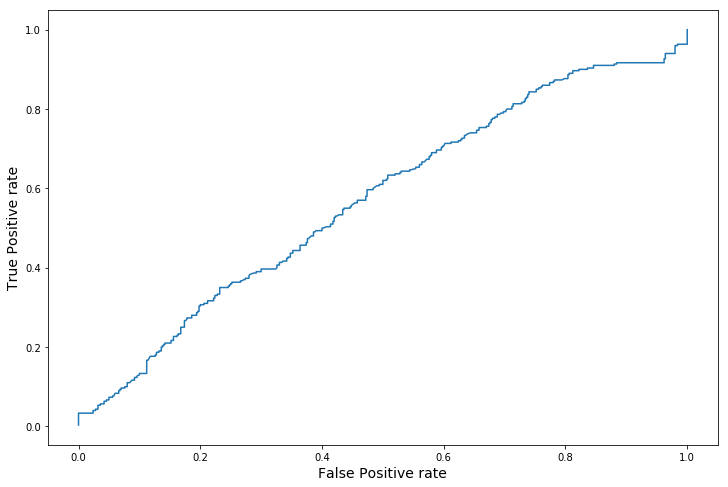

auc = 0.5711233333333333


,False Positive rate (fixed),False Negative rate
0,0.10,0.866667
1,0.15,0.790000
2,0.20,0.693333
3,0.30,0.603333


In [7]:
n_splits = 5

y = labels[TLE_noE_idx]["TLE/no E"]
data_TLE_noE = [data[i] for i in np.where(TLE_noE_idx == True)[0]]
pos_label = label_to_idx["TLE"]
pipe = SPD_pipeline(tr, 0.1)


best_model_TLE_noE, grid_cv_svc_TLE_noE, grid_cv_lr_TLE_noE, grid_cv_mdm_TLE_noE, grid_cv_knn_TLE_noE = pipe.train_grid_cv(
    data_TLE_noE, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_TLE_noE)
scores_TLE_noE = cross_val_score(best_model_TLE_noE, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_TLE_noE.mean())
print("std =", scores_TLE_noE.std())


pipe.save_model(best_model_TLE_noE, "models/fmri_rim_TLE_noE.pkl")
probas_TLE_noE = pipe.repeated_cross_val_predict_proba(best_model_TLE_noE, data_TLE_noE, y, cv=cv, pos_label=pos_label, file = 'models/rim_TLE_noE_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_TLE_noE, pos_label, TLE_noE_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_TLE_noE, pos_label, TLE_noE_idx)
pipe.get_fpr_fnr(fpr, tpr)
                           
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### TLE / Control

Target distribution: 
6.0    30
0.0    25
Name: TLE/C, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min


(training took 261.8620181083679s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   33.1s finished


(training took 34.210996866226196s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 0.0001, clf__gamma = 1, clf__kernel =...",0.658667,0.160286
LR,"clf__C = 1, metric = euclid",0.532000,0.141258
KNN,"metric = riemann, n_neighbors = 5",0.548000,0.149393
MDM,metric = riemann,0.513333,0.181108


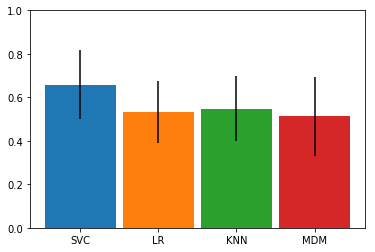

Best model: 
SVC
clf__C = 0.0001
clf__gamma = 1
clf__kernel = rbf
metric = riemann
mean = 0.6503333333333333
std = 0.14238016403667722


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

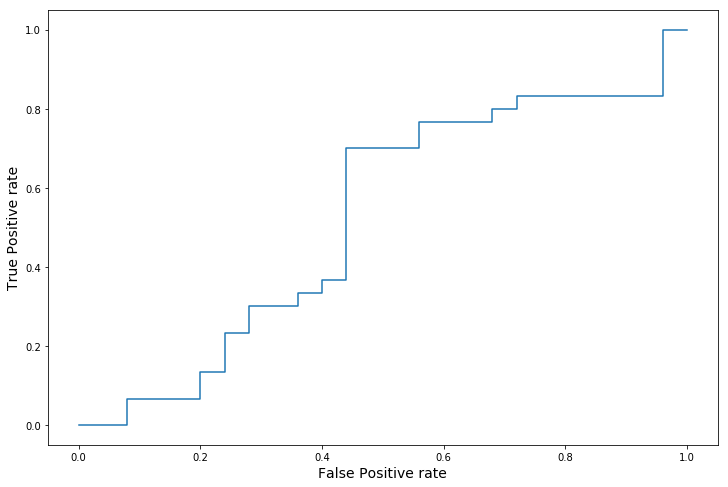

auc = 0.5226666666666666


,False Positive rate (fixed),False Negative rate
0,0.10,0.933333
1,0.15,0.933333
2,0.20,0.866667
3,0.30,0.700000


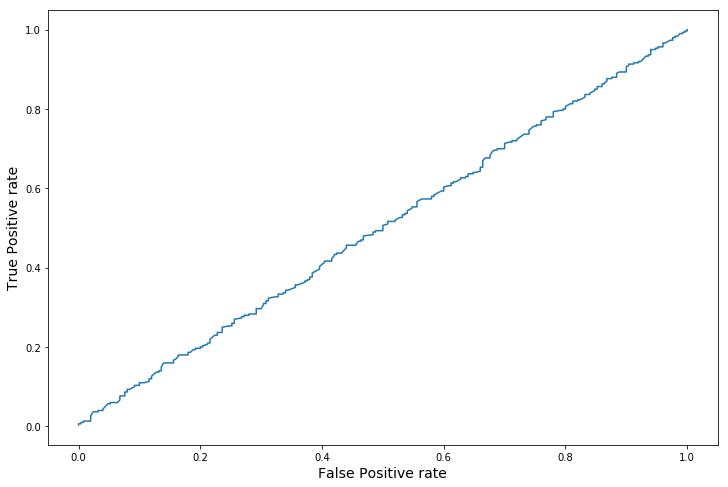

auc = 0.5030733333333333


,False Positive rate (fixed),False Negative rate
0,0.10,0.890000
1,0.15,0.840000
2,0.20,0.800000
3,0.30,0.703333


In [7]:
n_splits = 5

y = labels[TLE_C_idx]["TLE/C"]
data_TLE_C = [data[i] for i in np.where(TLE_C_idx == True)[0]]
pos_label = label_to_idx["TLE"]
pipe = SPD_pipeline(tr, 0.1)


best_model_TLE_C, grid_cv_svc_TLE_C, grid_cv_lr_TLE_C, grid_cv_mdm_TLE_C, grid_cv_knn_TLE_C = pipe.train_grid_cv(
    data_TLE_C, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_TLE_C)
scores_TLE_C = cross_val_score(best_model_TLE_C, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_TLE_C.mean())
print("std =", scores_TLE_C.std())


pipe.save_model(best_model_TLE_C, "models/fmri_rim_TLE_C.pkl")
probas_TLE_C = pipe.repeated_cross_val_predict_proba(best_model_TLE_C, data_TLE_C, y, cv=cv, pos_label=pos_label, file = 'models/rim_TLE_C_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_TLE_C, pos_label, TLE_C_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_TLE_C, pos_label, TLE_C_idx)
pipe.get_fpr_fnr(fpr, tpr)
                           
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Depression with epilepsy / Epilepsy

Target distribution: 
3.0    25
2.0    25
Name: DE/E, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min


(training took 4811.198042869568s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 80.2min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   41.0s finished


(training took 41.988588094711304s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 1, clf__gamma = 0.01, clf__kernel = r...",0.6128,0.159085
LR,"clf__C = 0.0001, metric = riemann",0.4512,0.160208
KNN,"metric = riemann, n_neighbors = 5",0.4128,0.145644
MDM,metric = riemann,0.4304,0.164450


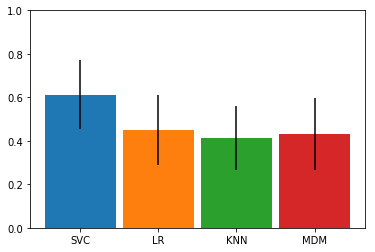

Best model: 
SVC
clf__C = 1
clf__gamma = 0.01
clf__kernel = rbf
metric = riemann
mean = 0.6328
std = 0.16505805039439914


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

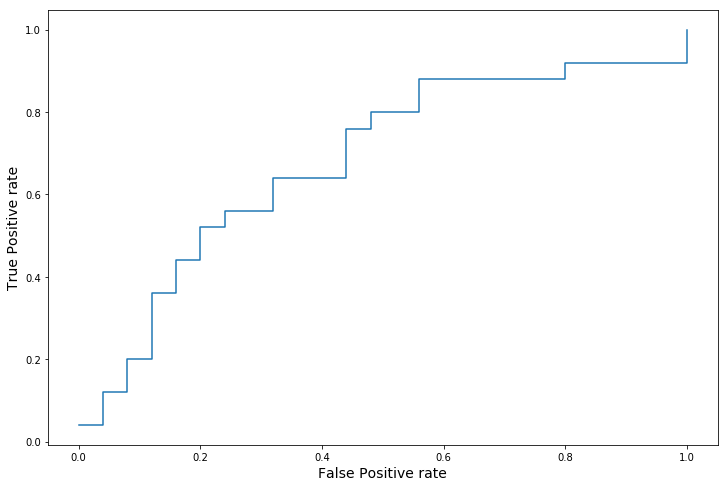

auc = 0.6784000000000001


,False Positive rate (fixed),False Negative rate
0,0.10,0.80
1,0.15,0.64
2,0.20,0.48
3,0.30,0.44


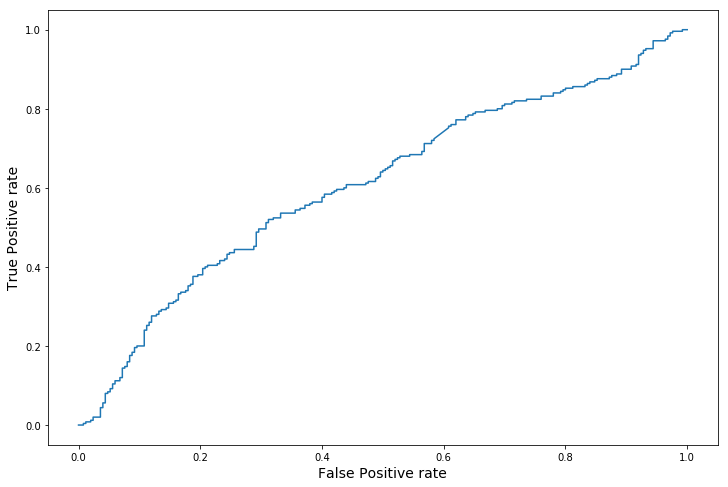

auc = 0.608864


,False Positive rate (fixed),False Negative rate
0,0.10,0.800
1,0.15,0.692
2,0.20,0.620
3,0.30,0.504


In [7]:
n_splits = 5

y = labels[DE_E_idx]["DE/E"]
data_DE_E = [data[i] for i in np.where(DE_E_idx == True)[0]]
pos_label = label_to_idx["DE"]
pipe = SPD_pipeline(tr, 0.1)


best_model_DE_E, grid_cv_svc_DE_E, grid_cv_lr_DE_E, grid_cv_mdm_DE_E, grid_cv_knn_DE_E = pipe.train_grid_cv(
    data_DE_E, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_DE_E)
scores_DE_E = cross_val_score(best_model_DE_E, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_DE_E.mean())
print("std =", scores_DE_E.std())


pipe.save_model(best_model_DE_E, "models/fmri_rim_DE_E.pkl")
probas_DE_E = pipe.repeated_cross_val_predict_proba(best_model_DE_E, data_DE_E, y, cv=cv, pos_label=pos_label, file = 'models/rim_DE_E_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DE_E, pos_label, DE_E_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DE_E, pos_label, DE_E_idx)
pipe.get_fpr_fnr(fpr, tpr)

                      
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')

### Depression with epilepsy / Depression

Target distribution: 
3    25
1    25
Name: target, dtype: int64 

loading fitted SVC...

loading fitted LR...

Training KNN...
Fitting 25 folds for each of 12 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min


(training took 212.65609908103943s)

Training MDM...
Fitting 25 folds for each of 3 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   29.7s finished


(training took 30.719256162643433s)

Scoring: roc_auc


,best parameters,mean,std
classifier,,,
SVC,"clf__C = 100, clf__gamma = 0.01, clf__kernel =...",0.6280,0.187446
LR,"clf__C = 0.01, metric = euclid",0.6736,0.204800
KNN,"metric = riemann, n_neighbors = 5",0.3808,0.160447
MDM,metric = riemann,0.6320,0.203647


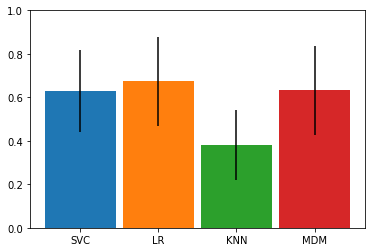

Best model: 
LR
clf__C = 0.01
metric = euclid
mean = 0.6624000000000001
std = 0.20986243113049083


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

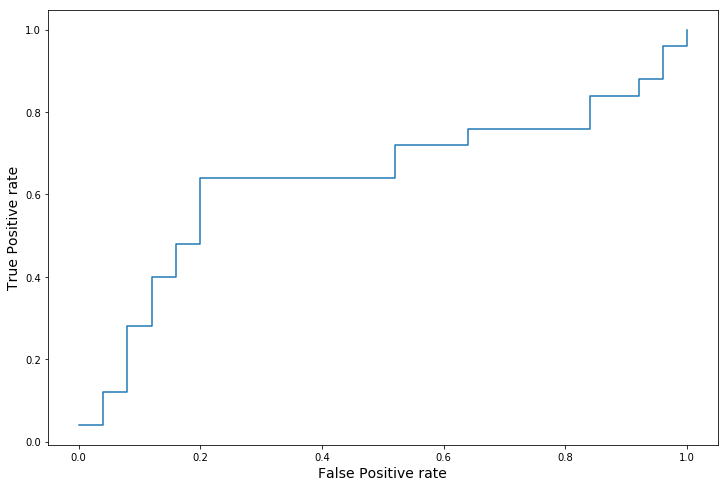

auc = 0.6367999999999999


,False Positive rate (fixed),False Negative rate
0,0.10,0.72
1,0.15,0.60
2,0.20,0.36
3,0.30,0.36


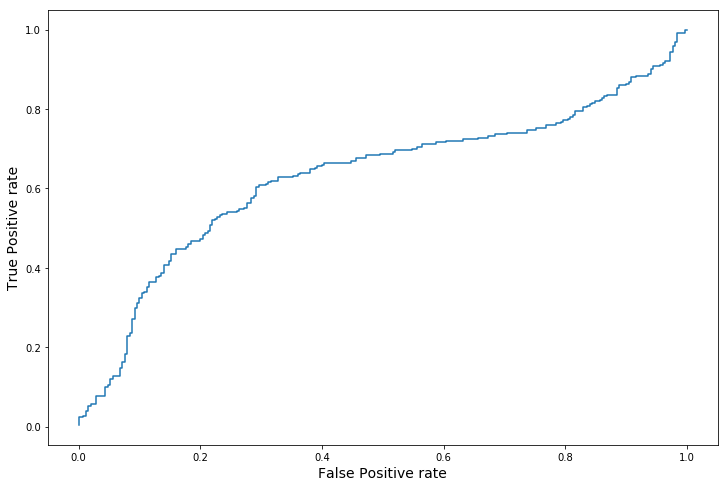

auc = 0.629216


In [7]:
n_splits = 5

y = labels[DE_D_idx]["target"]
data_DE_D = [data[i] for i in np.where(DE_D_idx == True)[0]]
pos_label = label_to_idx["DE"]
pipe = SPD_pipeline(tr, 0.1)


best_model_DE_D, grid_cv_svc_DE_D, grid_cv_lr_DE_D, grid_cv_mdm_DE_D, grid_cv_knn_DE_D = pipe.train_grid_cv(
    data_DE_D, y = y, n_splits=n_splits, n_repeats=5, scoring=scoring, random_state=42, n_jobs=-1, save_models_to = 'models/temp_model')


cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=10, random_state=42)
X = pipe.get_spd_dataset(data_DE_D)
scores_DE_D = cross_val_score(best_model_DE_D, X, np.array(y == pos_label).astype(int), cv=cv, scoring=scoring, n_jobs = -1)
print("mean =", scores_DE_D.mean())
print("std =", scores_DE_D.std())


pipe.save_model(best_model_DE_D, "models/fmri_rim_DE_D.pkl")
probas_DE_D = pipe.repeated_cross_val_predict_proba(best_model_DE_D, data_DE_D, y, cv=cv, pos_label=pos_label, file = 'models/rim_DE_D_prediction.csv')

# # average probabilities between repetitions
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DE_D, pos_label, DE_D_idx, average_repeats=True)
pipe.get_fpr_fnr(fpr, tpr)

# # without averaging
fpr, tpr, t = pipe.plot_roc_curve(y, probas_DE_D, pos_label, DE_D_idx)

                      
## Delete temp models
os.remove('models/temp_model_svc.pkl')
os.remove('models/temp_model_lr.pkl')
os.remove('models/temp_model_knn.pkl')
os.remove('models/temp_model_mdm.pkl')